# **Coding the full net** ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class Preprocessing:
    def __init__(self):
        pass

    def train_test_split(self, X, y, test_size=.20, seed = 5):
        """ 
        Recieves a X and y vector
        Returns:
                X_train, X_test, y_train, y_test
        """
        np.random.seed(seed)
        n_rows = X.shape[0]
        n_samples = int(np.ceil(X.shape[0]*.2))
        test_idexes = np.random.randint(0, X.shape[0], n_samples)
        train_indexes = [i for i in range(n_rows) if i not in test_idexes]


        return  X[train_indexes], X[test_idexes], y[train_indexes], y[test_idexes]


In [3]:
class Network():

    """
    Recieves the shape of each layer in the network and their activation function as a list of tuples
        [
          (10, 'sigmoid')     --> Layer 1 has 3 nodes
        ,  (3, 'relu)
        , (4, 'relu')    --> Layer 2 has 4 nodes
        , (1, 'sigmoid')    --> Outpur layer has 1 node
        ]
    """

    def __init__(self, layers):
        self.layers = layers
        self.weights, self.biases = self.initialize_weights(layers)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoidPrime(self, x):
        return x * (1 - x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def reluPrime(self, x):
        return np.where(x > 0, 1, 0)
    
    
    def functionsMapping(self, func_name):
        self.fs = { 
            "sigmoid": {"normal": self.sigmoid, "prime": self.sigmoidPrime},
            "relu": {"normal": self.relu, "prime": self.reluPrime}}
        
        return self.fs.get(func_name)
    
    def initialize_weights(self,layers):
        weights = []
        biases = []
        for i in range(len(layers) -1):
            w = np.random.randn(layers[i][0],layers[i+1][0]) * 0.01
            b = np.zeros((layers[i + 1][0], 1))
            weights.append(w)
            biases.append(b)
            
        return weights, biases
            

    def feedforwarding(self ,X): #Where to add bias here
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.weights[i].T,activations[-1]) + self.biases[i]

            if i>0:
                activationFunction = self.functionsMapping(self.layers[i][1]).get("normal")
                A = activationFunction(z)
            else:
                A = z
            
            activations.append(A)
        return activations
    
    def calculateLoss(self, Y,Y_pred):
        return np.mean((Y_pred - Y)**2)
    
    def backpropagation(self, activations, Y):
        m = Y.shape[1]
        wGradients = [np.zeros_like(w) for w in self.weights]
        bGradients = [np.zeros_like(b) for b in self.biases]

        delta = activations[-1] - Y

        for i in reversed(range(len(self.weights))): # Iterate backwards through each layer
            funcName = self.layers[i + 1][1] if i > 0 else None
            actDerivative = self.functionsMapping(funcName).get("prime")(activations[i+1]) if funcName else 1 #Passing the layer through the derivative function 

            dz = delta * actDerivative #Element wise multiplication. 
            #The derivative indicates how much the layer function would change if we change the previous weights
            #Then we multiply that with the delta, so we can change more the values that are the farthest and the ones that would make more impact to the funct

            wGradients[i] = np.dot(activations[i], dz.T) / m
            bGradients[i] = np.sum(dz, axis=1, keepdims=True) / m # Getting the average of all training exmple requested changes to bias


            if i > 0:
                delta = np.dot(self.weights[i],dz)

            #wGradients is a lit with the same amount of elements as weights list, and each element inside has the same shape
            #So, basically we're indicating how much to change each weights array, 3 elements bc we have 4 layers
            #weights array includes the weights of each combination of edges between layers for all samples in the dataset
            return wGradients, bGradients 
            

        

    def fit(self,X_train, y_train, epochs, learning_rate=0.01):
        X_train = X_train.T #X_train should have shape (n_features, n_samples)
        losses = []
        for epoch in range(epochs):

            #Compute forward for all samples in the dataset
            activations = self.feedforwarding(X_train)

            #Compute loss - Average delta between output layer value and pred value from all samples in the dataset
            loss = self.calculateLoss(y_train, activations[-1])
            losses.append(loss)

            #Backpropagation
            w_gradients, b_gradients = self.backpropagation(activations, y_train)

            #Updaate weights and biases
            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate*w_gradients[i]
                self.biases[i] -= learning_rate*b_gradients[i]

        return losses

    def predict(self,X):
        X = X.T
        activations = self.feedforwarding(X)
        return activations[-1]



Predictions: [[0.43999681 0.43999924 0.43999762 0.44000512]]
Binary Predictions: [[0 0 0 0]]


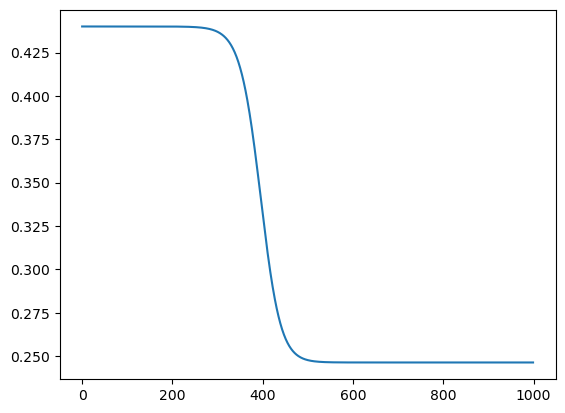

In [4]:
import numpy as np

# Instantiate the network
layers = [(2, None), (4, 'relu'), (4, 'relu'), (1, 'sigmoid')]  # 2 input features, hidden layers, 1 output neuron
nn = Network(layers)

# Create a toy dataset for binary classification
np.random.seed(42)
X_train = np.random.randn(100, 2)  # 100 samples, 2 features (x1, x2)
y_train = np.array([1 if x1 + x2 > 0 else 0 for x1, x2 in X_train])  # Label based on x1 + x2 > 0
y_train = y_train.reshape(1, -1)  # Reshape to (1, 100) for compatibility with the network

# Train the network
losses = nn.fit(X_train, y_train, epochs=1000, learning_rate=0.1)

# Test the model
X_test = np.array([[1, 1], [-1, -1], [0.5, 0.5], [-0.5, 1.5]])  # Example test samples
predictions = nn.predict(X_test)
print("Predictions:", predictions)

# Convert predictions to binary (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)
print("Binary Predictions:", binary_predictions)

plt.plot(range(len(losses)), losses, label='Values')